In [3]:
from tensorflow.keras.applications.mobilenet import MobileNet
img_row , img_col = 224 , 224 
mobilenet = MobileNet(weights = "imagenet" , 
                      include_top  = False , 
                      input_shape = (224 , 224 , 3))  
for layer in mobilenet.layers:
  layer.trainable = False 
for (i , layer) in enumerate(mobilenet.layers):
  print(str(i)+ " " + layer.__class__.__name__ , layer.trainable) 

0 InputLayer False
1 Conv2D False
2 BatchNormalization False
3 ReLU False
4 DepthwiseConv2D False
5 BatchNormalization False
6 ReLU False
7 Conv2D False
8 BatchNormalization False
9 ReLU False
10 ZeroPadding2D False
11 DepthwiseConv2D False
12 BatchNormalization False
13 ReLU False
14 Conv2D False
15 BatchNormalization False
16 ReLU False
17 DepthwiseConv2D False
18 BatchNormalization False
19 ReLU False
20 Conv2D False
21 BatchNormalization False
22 ReLU False
23 ZeroPadding2D False
24 DepthwiseConv2D False
25 BatchNormalization False
26 ReLU False
27 Conv2D False
28 BatchNormalization False
29 ReLU False
30 DepthwiseConv2D False
31 BatchNormalization False
32 ReLU False
33 Conv2D False
34 BatchNormalization False
35 ReLU False
36 ZeroPadding2D False
37 DepthwiseConv2D False
38 BatchNormalization False
39 ReLU False
40 Conv2D False
41 BatchNormalization False
42 ReLU False
43 DepthwiseConv2D False
44 BatchNormalization False
45 ReLU False
46 Conv2D False
47 BatchNormalization False
48

In [4]:
def addtopmodelmobilenet(bottom_model , num_classes):
  top_model = bottom_model.output 
  top_model = GlobalAveragePooling2D()(top_model) 
  top_model = Dense(1024 , activation = "relu")(top_model) 
  top_model = Dense(1024 , activation = "relu")(top_model) 
  top_model = Dense(512 , activation = "relu")(top_model) 
  top_model = Dense(num_classes , activation = "softmax")(top_model) 
  return top_model 


In [5]:
from keras.models import Sequential , Model 
from keras.layers import Dense , Dropout , Flatten , MaxPooling2D 
from keras.layers import Conv2D , Conv2DTranspose , GlobalAveragePooling2D 
num_classes = 3
FCHead = addtopmodelmobilenet(mobilenet , num_classes) 
model = Model(inputs = mobilenet.inputs , outputs = FCHead) 
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 14, 14, 512)      4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_9 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_9

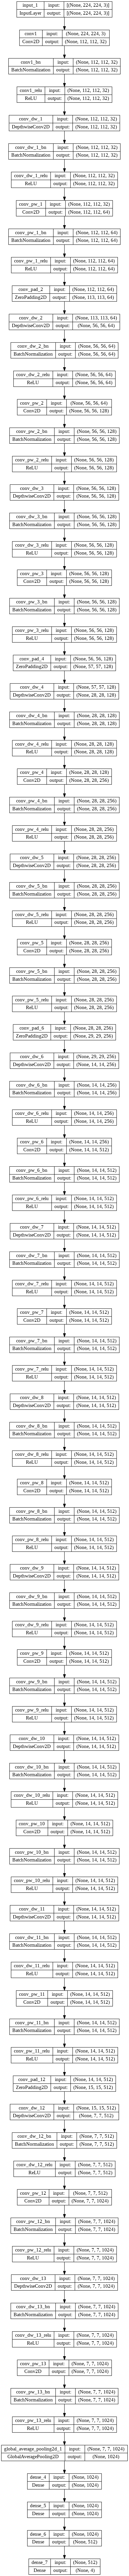

In [7]:
from tensorflow.keras.utils import plot_model 
plot_model(model , 
           to_file = "mobilenet.png" , 
           show_shapes = True
            )

In [8]:
from keras.preprocessing.image import ImageDataGenerator
train_dir = "Brain_Dataset/Training/"
test_dir = "Brain_Dataset/Testing/"

train_datagen = ImageDataGenerator(rescale = 1./255 , 
                                   shear_range = 0.2 , 
                                   zoom_range = 0.2 , 
                                   width_shift_range=0.3 , 
                                   height_shift_range = 0.3 , 
                                   horizontal_flip = True , 
                                   validation_split = 0.2) 
test_datagen = ImageDataGenerator(rescale = 1./255 ) 
train_set = train_datagen.flow_from_directory(train_dir , 
                                              class_mode = "categorical" , 
                                              batch_size = 16 , 
                                              target_size = (224 , 224)) 
validation_set = train_datagen.flow_from_directory(train_dir , 
                                              class_mode = "categorical" , 
                                              batch_size = 16 , 
                                              target_size = (224 , 224)) 
test_set = test_datagen.flow_from_directory(test_dir , 
                                              class_mode = "categorical" , 
                                              batch_size = 16 , 
                                              target_size = (224 , 224)) 

Found 2870 images belonging to 4 classes.
Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


In [7]:
from keras.callbacks import EarlyStopping , ModelCheckpoint , ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop

modelcheckpoint = ModelCheckpoint("/content/drive/MyDrive/mobilenet.h5" , 
                                  monitor = "val_loss" , 
                                  mode = "min" , 
                                  save_best_only = True , 
                                  verbose = 1) 
earlystop = EarlyStopping(monitor = "val_loss" , 
                          min_delta = 0 ,  
                          patience = 2,
                          verbose = 1 , 
                          restore_best_weights = True) 
reducelr = ReduceLROnPlateau(monitor = "val_loss" , 
                             factor = 0.2 , 
                             min_delta = 0.00001 , 
                             patience = 2 , 
                             verbose = 1)  
callbacks = [modelcheckpoint , earlystop , reducelr] 
model.compile(loss = "categorical_crossentropy" , 
              optimizer = RMSprop(learning_rate = 0.001 ) , 
              metrics = ["accuracy"]) 
epochs = 15 
batch_size = 16 
history = model.fit(train_set , 
                    epochs = epochs , 
                    batch_size = batch_size , 
                    validation_data = validation_set , 
                    callbacks = callbacks) 

Epoch 1/15
180/180 [==============================] - ETA: 0s - loss: 1.2271 - accuracy: 0.6258
Epoch 1: val_loss improved from inf to 0.53249, saving model to /content/drive/MyDrive/mobilenet.h5
180/180 [==============================] - 1522s 8s/step - loss: 1.2271 - accuracy: 0.6258 - val_loss: 0.5325 - val_accuracy: 0.7916 - lr: 0.0010
Epoch 2/15
180/180 [==============================] - ETA: 0s - loss: 0.5859 - accuracy: 0.7808
Epoch 2: val_loss did not improve from 0.53249
180/180 [==============================] - 83s 464ms/step - loss: 0.5859 - accuracy: 0.7808 - val_loss: 0.6594 - val_accuracy: 0.7627 - lr: 0.0010
Epoch 3/15
180/180 [==============================] - ETA: 0s - loss: 0.5185 - accuracy: 0.8265
Epoch 3: val_loss improved from 0.53249 to 0.35857, saving model to /content/drive/MyDrive/mobilenet.h5
180/180 [==============================] - 85s 472ms/step - loss: 0.5185 - accuracy: 0.8265 - val_loss: 0.3586 - val_accuracy: 0.8617 - lr: 0.0010
Epoch 4/15
180/180 [=

In [ ]:
import matplotlib.pyplot as plt
history_dict = history.history 
loss_val = history_dict["loss"] 
val_loss = history_dict["val_loss"]
epochs = range(1, len(loss_val)+1) 

line1 = plt.plot(epochs , loss_val , label = "training_loss") 
line2 = plt.plot(epochs , val_loss , label = "validation_loss")
plt.setp(line1 , linewidth = 2.0 , marker = "+" , markersize = 10.0) 
plt.setp(line2 , linewidth = 2.0 , marker = "4" , markersize = 10.0)
plt.title("Training_And_Validation_Loss_Visual") 
plt.xlabel("Epochs") 
plt.ylabel("Loss") 
plt.legend() 
plt.grid(True) 
plt.show() 

In [ ]:
acc_val = history_dict["accuracy"] 
val_acc = history_dict["val_accuracy"] 
epochs = range(1 , len(val_acc)+1) 

line1 = plt.plot(epochs , acc_val , label = "Training_Accuracy") 
line2 = plt.plot(epochs , val_acc , label = "Validation_accuracy") 
plt.setp(line1 , linewidth = 2.0 , marker = "+" , markersize = 10.0) 
plt.setp(line2 , linewidth = 2.0 , marker = "4" , markersize = 10.0)  
plt.title("Training_And_Validation_Accuracy")
plt.xlabel("Epoxhs") 
plt.ylabel("Loss") 
plt.legend()
plt.grid(True) 
plt.show()

In [ ]:
_ , test_acc = model.evaluate(test_set , steps = None , callbacks = None , max_queue_size = 10 , workers = 1 , use_multiprocessing=False) 
print("test_acc" , test_acc *100)

In [2]:
from keras.models import load_model 
model = load_model("models_weights/mobilenet.h5") 

In [28]:
import cv2 
import os 
import numpy as np 
from os import listdir 
from os.path import isfile , join 

brain_detection_dict = {"[0]":"glioma" ,
                       "[1]" : "meningioma" ,
                       "[2]":"pituitary"}
brain_detection_dict_n = {"glioma":"glioma" ,
                       "meningioma" : "meningioma" ,
                       "pituitary" : "pituitary"} 
def draw_test(name, pred , im):
    lungs = brain_detection_dict[str(pred)]
    BLACK = [0,0,0]
    expanded_image = cv2.copyMakeBorder(im , 80 , 0,0,100 , cv2.BORDER_CONSTANT , value = BLACK)
    cv2.putText(expanded_image , lungs , (20,60) , cv2.FONT_HERSHEY_SIMPLEX , 1 , (0,255,0) , 2) 
    return cv2.imshow(name , expanded_image)
def get_random_test(path):
    folder = list(filter(lambda x: os.path.isdir(os.path.join(path , x)) ,os.listdir(path)))
    random_directory = np.random.randint(0 , len(folder))
    path_class = folder[random_directory]
    print("predicted_class :" + brain_detection_dict_n[str(path_class)]) 
    file_path = path + path_class 
    file_name = [f for f in listdir(file_path) if isfile(join(file_path , f))]
    random_directory_index = np.random.randint(0 , len(file_name))
    image_name = file_name[random_directory_index]
    return cv2.imread(file_path + "/" + image_name)
for i in range(0 , 10):
    input_im = get_random_test("Brain_Dataset/Testing/")
    original_im = input_im.copy()
    original_im = cv2.resize(original_im , None , fx = 0.7 , fy = 0.7 , interpolation = cv2.INTER_NEAREST) 
    
    input_im = cv2.resize(input_im , (224 ,224 ) , interpolation = cv2.INTER_NEAREST)
    input_im = input_im / 255. 
    input_im = input_im.reshape(1,224 ,224 , 3) 
    res = np.argmax(model.predict(input_im , 1 , verbose=0) , axis = 1) 
    draw_test("prediction" , res , original_im)
    cv2.waitKey(0)
cv2.destroyAllWindows()

predicted_class :pituitary
predicted_class :pituitary
predicted_class :meningioma
predicted_class :pituitary
predicted_class :meningioma
predicted_class :meningioma
predicted_class :glioma
predicted_class :meningioma
predicted_class :meningioma
predicted_class :meningioma


Prediction pituitary


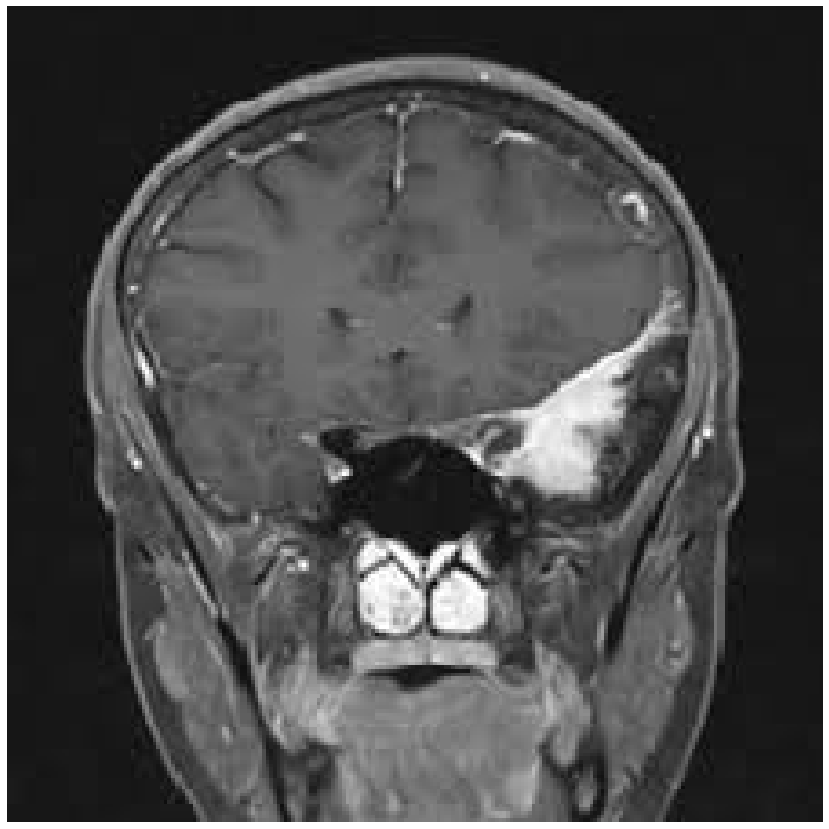

In [32]:
from tensorflow.keras.preprocessing.image import load_img , img_to_array 
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt 
img = load_img("Brain_Dataset/Testing/meningioma/Te-meTr_0003.jpg" , target_size = (224 , 224))
original_img = load_img("Brain_Dataset/Testing/meningioma/Te-meTr_0003.jpg" , target_size = (224 , 224)) 
img = img_to_array(img) 
img = tf.expand_dims(img , axis = 0) 
predict = model.predict(np.array(img))  
brain_detection_dict = {0:"glioma" ,
                       1 : "meningioma" ,
                       2:"pituitary"}
fig = plt.figure(figsize = (16 , 15))                        
plt.axis("off") 
plt.imshow(original_img) 
print("Prediction" , brain_detection_dict[np.argmax(predict[0])])

In [28]:
glioma = load_img("Brain_Dataset/Testing/glioma_tumor/image(10).jpg" , target_size = (224 , 224))
meningioma = load_img("Brain_Dataset/Testing/meningioma_tumor/image(100).jpg" , target_size = (224 , 224))
no_tumor = load_img("Brain_Dataset/Testing/no_tumor/image(100).jpg" , target_size = (224 , 224))
pituitary = load_img("Brain_Dataset/Testing/pituitary_tumor/image(98).jpg" , target_size = (224 , 224))  
def loss(output):
    return(output[0][0] , output[1][1] , output[2][2] , output[3][3]) 
def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear 
    return m 

In [24]:
!pip install tf_keras_vis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 KB 4.6 MB/s eta 0:00:00


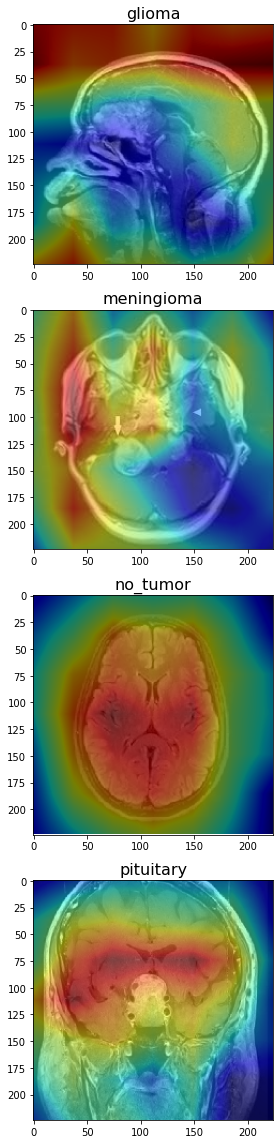

In [29]:
import tensorflow as tf 
from keras.applications.mobilenet import preprocess_input
from tf_keras_vis.utils import normalize
from tf_keras_vis.gradcam import Gradcam
from matplotlib import cm  
gradcam = Gradcam(model , 
                  model_modifier , 
                  clone = False )
images = np.asarray([np.array(glioma) , np.array(meningioma) , np.array(no_tumor) , np.array(pituitary)])
X = preprocess_input(images) 
cam = gradcam(loss , 
              X , 
              penultimate_layer=-1)
cam = normalize(cam) 
titles = ["glioma" , "meningioma" , "no_tumor" , "pituitary"]
f , ax = plt.subplots(4 , 1 , figsize = (16, 16))
for (i , title) in enumerate(titles):
    heatmap = np.uint8(cm.jet(cam[i])[... ,:3]*255)
    ax[i].set_title(title , fontsize = 16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap , cmap = "jet" , alpha = 0.5)
plt.tight_layout()
plt.show()

Found 394 images belonging to 4 classes.
25/25 [==============================] - 96s 4s/step
Confusion Matrix
[[ 3 42 35 20]
 [10 43 46 16]
 [ 4 50 34 17]
 [ 4 30 27 13]]
Classification Report
                  precision    recall  f1-score   support

    glioma_tumor       0.14      0.03      0.05       100
meningioma_tumor       0.26      0.37      0.31       115
        no_tumor       0.24      0.32      0.28       105
 pituitary_tumor       0.20      0.18      0.19        74

        accuracy                           0.24       394
       macro avg       0.21      0.23      0.20       394
    weighted avg       0.21      0.24      0.21       394



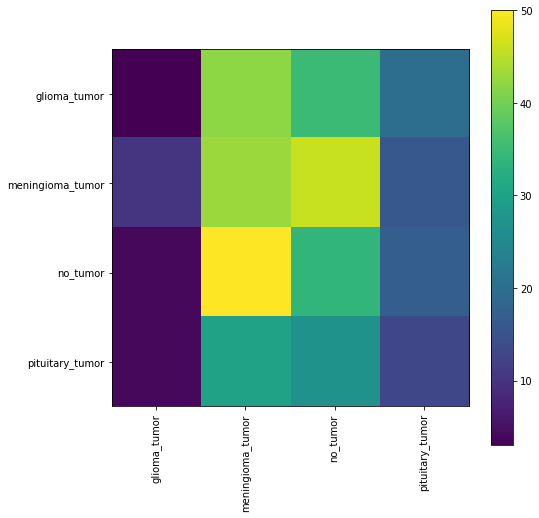

In [30]:
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# We need to recreate our validation generator with shuffle = false
test_set = train_datagen.flow_from_directory(test_dir , 
                                            target_size= (224 , 224) , 
                                            class_mode = "categorical" ,
                                            batch_size=16)

class_labels = test_set.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())


nb_validation_samples = 541
batch_size = 16

#Confution Matrix and Classification Report
Y_pred = model.predict(test_set ,  nb_validation_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(test_set.classes, y_pred))
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
cnf_matrix = confusion_matrix(test_set.classes, y_pred)

plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)